In [1]:
#@author yuetian
from torchvision.ops.boxes import batched_nms
import torch
import argparse
import os
import numpy as np
import itertools
from tqdm import tqdm
from PIL import Image


from models.prob_deformable_detr import build
import torch
import matplotlib.pyplot as plt

from main_open_world import get_datasets
from torch.utils.data import DataLoader
import datasets.samplers as samplers
from torchvision.transforms import functional as F
from util.misc import init_distributed_mode, collate_fn, MetricLogger, SmoothedValue

{'OWDETR': ('aeroplane', 'bicycle', 'bird', 'boat', 'bus', 'car', 'cat', 'cow', 'dog', 'horse', 'motorbike', 'sheep', 'train', 'elephant', 'bear', 'zebra', 'giraffe', 'truck', 'person', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'chair', 'diningtable', 'pottedplant', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'bed', 'toilet', 'sofa', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'tvmonitor', 'bottle', 'unknown'), 'TOWOD': ('aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',

# Reference: params setting for task 1 eval
```
Namespace(lr=0.0002, lr_backbone_names=['backbone.0'], lr_backbone=2e-05, lr_linear_proj_names=['reference_points', 'sampling_offsets'], lr_linear_proj_mult=0.1, batch_size=5, weight_decay=0.0001, epochs=191, lr_drop=35, lr_drop_epochs=None, clip_max_norm=0.1, sgd=False, with_box_refine=False, two_stage=False, masks=False, backbone='dino_resnet50', frozen_weights=None, dilation=False, position_embedding='sine', position_embedding_scale=6.283185307179586, num_feature_levels=4, enc_layers=6, dec_layers=6, dim_feedforward=1024, hidden_dim=256, dropout=0.1, nheads=8, num_queries=100, dec_n_points=4, enc_n_points=4, aux_loss=True, set_cost_class=2, set_cost_bbox=5, set_cost_giou=2, cls_loss_coef=2, bbox_loss_coef=5, giou_loss_coef=2, focal_alpha=0.25, coco_panoptic_path=None, remove_difficult=False, output_dir='exps/SOWODB/PROB/eval', device='cuda', seed=42, resume='', start_epoch=0, eval=True, viz=False, eval_every=5, num_workers=3, cache_mode=False, PREV_INTRODUCED_CLS=0, CUR_INTRODUCED_CLS=19, unmatched_boxes=False, top_unk=5, featdim=1024, invalid_cls_logits=False, NC_branch=False, bbox_thresh=0.3, pretrain='exps/SOWODB/PROB/t1.pth', nc_loss_coef=2, train_set='owdetr_t1_train', test_set='owdetr_test', num_classes=81, nc_epoch=0, dataset='OWDETR', data_root='/training_data_2/yuetian/OWOD', unk_conf_w=1.0, model_type='prob', wandb_name='prob_original', wandb_project='', obj_loss_coef=0.0008, obj_temp=1.3, freeze_prob_model=False, num_inst_per_class=50, exemplar_replay_selection=False, exemplar_replay_max_length=10000000000.0, exemplar_replay_dir='', exemplar_replay_prev_file='', exemplar_replay_cur_file='', exemplar_replay_random=False)
```

```
 Namespace(lr=0.0002, lr_backbone_names=['backbone.0'], lr_backbone=2e-05, lr_linear_proj_names=['reference_points', 'sampling_offsets'], lr_linear_proj_mult=0.1, batch_size=1, weight_decay=0.0001, epochs=41, lr_drop=35, lr_drop_epochs=None, clip_max_norm=0.1, sgd=False, with_box_refine=False, two_stage=False, masks=False, backbone='dino_resnet50', frozen_weights=None, dilation=False, position_embedding='sine', position_embedding_scale=6.283185307179586, num_feature_levels=4, enc_layers=6, dec_layers=6, dim_feedforward=1024, hidden_dim=256, dropout=0.1, nheads=8, num_queries=100, dec_n_points=4, enc_n_points=4, aux_loss=True, set_cost_class=2, set_cost_bbox=5, set_cost_giou=2, cls_loss_coef=2, bbox_loss_coef=5, giou_loss_coef=2, focal_alpha=0.25, coco_panoptic_path=None, remove_difficult=False, output_dir='exps/MOWODB/PROB/t1', device='cuda', seed=42, training_seed=24, resume='', start_epoch=0, eval=False, viz=False, eval_every=5, num_workers=3, cache_mode=False, PREV_INTRODUCED_CLS=0, CUR_INTRODUCED_CLS=20, unmatched_boxes=False, top_unk=5, featdim=1024, invalid_cls_logits=False, NC_branch=False, bbox_thresh=0.3, pretrain='', nc_loss_coef=2, train_set='owod_t1_train', test_set='owod_all_task_test', num_classes=81, nc_epoch=0, dataset='TOWOD', data_root='/training_data_2/yuetian/OWOD', unk_conf_w=1.0, model_type='prob', wandb_name='PROB_V1_t1', wandb_project='', obj_loss_coef=0.0008, obj_temp=1.3, freeze_prob_model=False, num_inst_per_class=50, exemplar_replay_selection=True, exemplar_replay_max_length=850, exemplar_replay_dir='PROB_V1', exemplar_replay_prev_file='', exemplar_replay_cur_file='learned_owod_t1_ft_1.txt', exemplar_replay_random=False)
```


In [2]:
seed=25
args_dict = {
    'lr': 0.0002, 'lr_backbone_names': ['backbone.0'], 
    'lr_backbone': 2e-05, 'lr_linear_proj_names': ['reference_points', 'sampling_offsets'], 
    'lr_linear_proj_mult': 0.1, 'batch_size': 1, 'weight_decay': 0.0001, 'epochs': 191, 'lr_drop': 35, 
    'lr_drop_epochs': None, 'clip_max_norm': 0.1, 'sgd': False, 'with_box_refine': False, 'two_stage': False, 
    'masks': False, 'backbone': 'dino_resnet50', 'frozen_weights': None, 'dilation': False, 'position_embedding': 'sine', 
    'position_embedding_scale': 6.283185307179586, 'num_feature_levels': 4, 'enc_layers': 6, 'dec_layers': 6, 
    'dim_feedforward': 1024, 'hidden_dim': 256, 'dropout': 0.1, 'nheads': 8, 'num_queries': 100, 
    'dec_n_points': 4, 'enc_n_points': 4, 'aux_loss': True, 'set_cost_class': 2, 'set_cost_bbox': 5, 
    'set_cost_giou': 2, 'cls_loss_coef': 2, 'bbox_loss_coef': 5, 'giou_loss_coef': 2, 
    'focal_alpha': 0.25, 'coco_panoptic_path': None, 'remove_difficult': False, 'output_dir': f'exps/MOWODB/PROB/t1/{seed}-checkpoint0039.pth', 
    'device': 'cuda:0', 'seed': 42, 'resume': '', 'start_epoch': 0, 'eval': True, 'viz': False, 'eval_every': 5, 'num_workers': 3, 
    'cache_mode': False, 'PREV_INTRODUCED_CLS': 0, 'CUR_INTRODUCED_CLS': 19, 'unmatched_boxes': False, 'top_unk': 5, 'featdim': 1024, 
    'invalid_cls_logits': False, 'NC_branch': False, 'bbox_thresh': 0.3, 'pretrain': 'exps/MOWODB/PROB/t1.pth', 'nc_loss_coef': 2, 
    'train_set': 'owdetr_t1_train', 'test_set': 'owdetr_test', 'num_classes': 81, 'nc_epoch': 0, 'dataset': 'OWDETR', 
    'data_root': '/training_data_2/yuetian/OWOD', 'unk_conf_w': 1.0, 'model_type': 'prob', 'wandb_name': 'prob_original', 
    'wandb_project': '', 'obj_loss_coef': 0.0008, 'obj_temp': 1.3, 'freeze_prob_model': False, 'num_inst_per_class': 50, 
    'exemplar_replay_selection': False, 'exemplar_replay_max_length': 10000000000.0, 'exemplar_replay_dir': '', 
    'exemplar_replay_prev_file': '', 'exemplar_replay_cur_file': '', 'exemplar_replay_random': False
}

args = argparse.Namespace(**args_dict)


In [3]:
VOC_CLASS_NAMES_COCOFIED = [
    "airplane",  "dining table", "motorcycle",
    "potted plant", "couch", "tv"
]

BASE_VOC_CLASS_NAMES = [
    "aeroplane", "diningtable", "motorbike",
    "pottedplant",  "sofa", "tvmonitor"
]

VOC_CLASS_NAMES = [
    "aeroplane","bicycle","bird","boat","bus","car",
    "cat","cow","dog","horse","motorbike","sheep","train",
    "elephant","bear","zebra","giraffe","truck","person"
]

T2_CLASS_NAMES = [
    "traffic light","fire hydrant","stop sign",
    "parking meter","bench","chair","diningtable",
    "pottedplant","backpack","umbrella","handbag",
    "tie","suitcase","microwave","oven","toaster","sink",
    "refrigerator","bed","toilet","sofa"
]

T3_CLASS_NAMES = [
    "frisbee","skis","snowboard","sports ball",
    "kite","baseball bat","baseball glove","skateboard",
    "surfboard","tennis racket","banana","apple","sandwich",
    "orange","broccoli","carrot","hot dog","pizza","donut","cake"
]

T4_CLASS_NAMES = [
    "laptop","mouse","remote","keyboard","cell phone","book",
    "clock","vase","scissors","teddy bear","hair drier","toothbrush",
    "wine glass","cup","fork","knife","spoon","bowl","tvmonitor","bottle"
]

UNK_CLASS = ["unknown"]

VOC_COCO_CLASS_NAMES = tuple(itertools.chain(VOC_CLASS_NAMES, T2_CLASS_NAMES, T3_CLASS_NAMES, T4_CLASS_NAMES, UNK_CLASS))
print(VOC_COCO_CLASS_NAMES)

CLASSES = list(VOC_COCO_CLASS_NAMES)
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

('aeroplane', 'bicycle', 'bird', 'boat', 'bus', 'car', 'cat', 'cow', 'dog', 'horse', 'motorbike', 'sheep', 'train', 'elephant', 'bear', 'zebra', 'giraffe', 'truck', 'person', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'chair', 'diningtable', 'pottedplant', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'bed', 'toilet', 'sofa', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'tvmonitor', 'bottle', 'unknown')


In [4]:
def viz(model, criterion, data_loader, dataset, device, output_dir='./output', allow_unknown=True):
    mode = "no_unknown" if not allow_unknown else "filtered_unknown"
    os.makedirs(os.path.join(output_dir, f"./vali_loader/{mode}/"), exist_ok=True)
    model.eval()
    criterion.eval()

    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.add_meter('class_error', SmoothedValue(window_size=1, fmt='{value:.2f}'))

    num_obj = 20
    for batch_idx, (samples, targets) in enumerate(tqdm(data_loader)):
        if batch_idx >=10:
            break
        samples = samples.to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        top_k = len(targets[0]['boxes'])

        outputs = model(samples)
        if allow_unknown:
            probas = outputs['pred_logits'].softmax(-1)[0, :, :].cpu()
        else:
            probas = outputs['pred_logits'].softmax(-1)[0, :, :-1].cpu()
        pred_objs = outputs['pred_obj'].softmax(-1)[0, :].cpu()
        predicted_boxes = outputs['pred_boxes'][0,].cpu()
        scores, predicted_boxes = filter_boxes(probas, predicted_boxes)
        labels = scores.argmax(axis=1)
        scores = scores.max(-1).values
        
    # Filter if contains unknown
    if allow_unknown:
        print("start_filtering")
        iou_threshold = 0.4
        unknown_class_idx = 80  # Assuming the last class is "unknown"
        keep_indices = []

        # Get indices of "unknown" predictions
        unknown_indices = (labels == unknown_class_idx).nonzero(as_tuple=True)[0]
        # print(f"unknown indicies: {unknown_indices} - {labels}")
        
        # Loop over each "unknown" bounding box
        for idx, (box, lbl) in enumerate(zip(predicted_boxes, labels)):
            if lbl == unknown_class_idx:
                keep_unknown = True
                for known_box in predicted_boxes[labels != unknown_class_idx]:
                    if overlap_rate(image_tensor[0:1], box, known_box) > iou_threshold:
                        keep_unknown = False
                        # print("drop")
                        break
                if keep_unknown:
                    keep_indices.append(idx)
            else:
                keep_indices.append(idx)
                
        # Use the indices to filter the predictions
        predicted_boxes = predicted_boxes[keep_indices]
        labels = labels[keep_indices]
        scores = scores[keep_indices]

        # Save bbox, label, and probability info
        save_bbox_info(os.path.join(output_dir, f"./vali_loader/{mode}/"), 
                       targets[0]["image_id"][0], 
                       predicted_boxes, 
                       labels, 
                       scores,
                       samples.tensors[0:1])

        fig, ax = plt.subplots(1, 3, figsize=(10,3), dpi=200)

        # Ori Picture
        plot_ori_image(
            samples.tensors[0:1],
            ax[0], 
            plot_prob=False,
        )
        ax[0].set_title('Original Image')

        plot_prediction(
            samples.tensors[0:1], 
            scores[-top_k:], 
            predicted_boxes[-top_k:].detach().cpu(), 
            labels[-top_k:], 
            ax[1], 
            plot_prob=False,
            dataset=dataset,
        )
        ax[1].set_title('Prediction (Ours)')

        # GT Results
        plot_prediction(
            samples.tensors[0:1], 
            torch.ones(targets[0]['boxes'].shape[0]), 
            targets[0]['boxes'].detach().cpu(), 
            targets[0]['labels'],
            ax[2], 
            plot_prob=False,
            dataset=dataset,
        )
        ax[2].set_title('GT')

        for i in range(3):
            ax[i].set_aspect('equal')
            ax[i].set_axis_off()
        
        plt.savefig(os.path.join(output_dir, f'vali_loader/{mode}/img_{int(targets[0]["image_id"][0])}.jpg'))


In [5]:
def viz_single_img(model, criterion, image_path, dataset, device, output_dir='./output', allow_unknown=True):
    mode = "no_unknown" if not allow_unknown else "filtered_unknown"
    os.makedirs(os.path.join(output_dir, f"./custom/{mode}/"), exist_ok=True)
    model.eval()
    criterion.eval()

    use_topk = True
    num_obj = 20

    # Load the image and preprocess
    image = Image.open(image_path)
    image_tensor = F.to_tensor(image).unsqueeze(0).to(device)
    # Normalize the image tensor
    means = torch.tensor([0.485, 0.456, 0.406]).to(device).view(1, 3, 1, 1)
    stds = torch.tensor([0.229, 0.224, 0.225]).to(device).view(1, 3, 1, 1)
    image_tensor = (image_tensor - means) / stds

    # Forward pass
    outputs = model(image_tensor)

    if allow_unknown:
        probas = outputs['pred_logits'].softmax(-1)[0, :, :].cpu()
    else:
        probas = outputs['pred_logits'].softmax(-1)[0, :, :-1].cpu()
    predicted_boxes = outputs['pred_boxes'][0,].cpu()

    # print(probas, predicted_boxes)
    scores, predicted_boxes = filter_boxes(probas, predicted_boxes)
    labels = scores.argmax(axis=1)
    scores = scores.max(-1).values  


    iou_threshold = 0.4
    unknown_class_idx = 80  # Assuming the last class is "unknown"
    keep_indices = []

    # Get indices of "unknown" predictions
    unknown_indices = (labels == unknown_class_idx).nonzero(as_tuple=True)[0]
    # print(f"unknown indicies: {unknown_indices} - {labels}")
    
    # Loop over each "unknown" bounding box
    for idx, (box, lbl) in enumerate(zip(predicted_boxes, labels)):
        if lbl == unknown_class_idx:
            keep_unknown = True
            for known_box in predicted_boxes[labels != unknown_class_idx]:
                if overlap_rate(image_tensor[0:1], box, known_box) > iou_threshold:
                    keep_unknown = False
                    # print("drop")
                    break
            if keep_unknown:
                keep_indices.append(idx)
        else:
            keep_indices.append(idx)
        

    # Visualization
    fig, ax = plt.subplots(1, 4, figsize=(10,3), dpi=200)

    # Original Image
    plot_ori_image(image_tensor[0:1], ax[0], plot_prob=False)
    ax[0].set_title('Original Image')

    # Prediction
    top_k = 5
    # Ori Picture
    plot_ori_image(
        image_tensor[0:1],
        ax[0], 
        plot_prob=False,
    )
    ax[0].set_title('Original Image', fontsize = 7)

    # Pred results
    # if not control the number of labels
    plot_prediction(
        image_tensor[0:1], 
        scores[-num_obj:], 
        predicted_boxes[-num_obj:].detach().cpu(), 
        labels[-num_obj:], 
        ax[1], 
        plot_prob=False,
        dataset=dataset,
    )
    ax[1].set_title('Prediction (No Filter, No Top-k)', fontsize = 7)

    # Use the indices to filter the predictions
    predicted_boxes = predicted_boxes[keep_indices]
    labels = labels[keep_indices]
    scores = scores[keep_indices]

    plot_prediction(
        image_tensor[0:1], 
        scores[-num_obj:], 
        predicted_boxes[-num_obj:].detach().cpu(), 
        labels[-num_obj:], 
        ax[2], 
        plot_prob=False,
        dataset=dataset,
    )
    ax[2].set_title('Prediction (Filtered, no Top-k)', fontsize = 7)

    # if control the number of labels
    plot_prediction(
        image_tensor[0:1], 
        scores[-top_k:], 
        predicted_boxes[-top_k:].detach().cpu(), 
        labels[-top_k:], 
        ax[3], 
        plot_prob=False,
        dataset=dataset,
    )
    ax[3].set_title('Prediction (w/ Top-k)', fontsize = 7)


    for i in range(4):
        ax[i].set_aspect('equal')
        ax[i].set_axis_off()

    plt.savefig(os.path.join(output_dir, f'viz_{os.path.basename(image_path)}'))
    plt.show()
    save_bbox_info(os.path.join(output_dir, f"./custom/{mode}/"), os.path.basename(image_path), predicted_boxes, labels, scores, [image])

In [6]:
def overlap_rate(image, boxA, boxB):
    h, w = image[0].permute(1, 2, 0).detach().cpu().numpy().shape[:-1]
    boxA = rescale_bboxes(boxA, [w, h]).detach().cpu().numpy()
    boxB = rescale_bboxes(boxB, [w, h]).detach().cpu().numpy()
    # print(boxA, boxB)
    # Determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Compute the area of intersection rectangle
    interArea = max(0, xB - xA) * max(0, yB - yA)

    # Compute the area of box A
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])

    # Compute the overlap rate
    rate = interArea / boxAArea
    return rate

### You can choose confidence: the default value of confidence is 0.7
def filter_boxes(scores, boxes, confidence=0.7, apply_nms=True, iou=0.5):
    keep = scores.max(-1).values > confidence
    scores, boxes = scores[keep], boxes[keep]
 
    if apply_nms:
        top_scores, labels = scores.max(-1)
        keep = batched_nms(boxes, top_scores, labels, iou)
        scores, boxes = scores[keep], boxes[keep]
 
    return scores, boxes

def save_bbox_info(output_dir, image_id, bboxes, labels, scores, images):
    """
    Save bounding box, label, and probability info to a text file.
    """
    with open(os.path.join(output_dir, f'info_{image_id}.txt'), 'w') as f:
        for bbox, label_index, score, image in zip(bboxes, labels, scores, images):
            # boxes = [rescale_bboxes(boxes[i], [w, h]).cpu() for i in range(len(boxes))]
            # h, w = pil_img.shape[:-1]
            label_name = CLASSES[label_index]
            f.write(f"BBOX: {bbox.tolist()}, LABEL: {label_name} (ID: {label_index.item()}), PROB: {score.item()}\n")

def bbox_iou(boxA, boxB):
    # Determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # Compute the area of both the prediction and ground-truth rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # Compute the intersection over union
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # print(iou)
    return iou


def plot_image(ax, img, norm):
    if norm:
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = (img * 255)
    img = img.astype('uint8')
    ax.imshow(img)

def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=-1)
    
def rescale_bboxes(out_bbox, size):
    # print(size)
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32).to(out_bbox)
    return b

def plot_prediction(image, scores, boxes, labels, ax=None, plot_prob=True, dataset='OWOD'):    
    if ax is None:
        ax = plt.gca()
    plot_results(image[0].permute(1, 2, 0).detach().cpu().numpy(), scores, boxes, labels, ax, plot_prob=plot_prob, dataset=dataset)

def plot_ori_image(image, ax=None, plot_prob=False):    
    if ax is None:
        ax = plt.gca()
    plot_results(image[0].permute(1, 2, 0).detach().cpu().numpy(), None, None, None, ax)

def plot_results(pil_img, scores, boxes, labels, ax, plot_prob=True, norm=True, dataset='OWOD'):
    from matplotlib import pyplot as plt
    h, w = pil_img.shape[:-1]
    # w, h = pil_img.shape[:-1]
    image = plot_image(ax, pil_img, norm)
    colors = COLORS * 100
    if boxes is not None:
        boxes = [rescale_bboxes(boxes[i], [w, h]).cpu() for i in range(len(boxes))]
        for sc, cl, (xmin, ymin, xmax, ymax), c in zip(scores, labels, boxes, colors):
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                       fill=False, color=c, linewidth=2))
            # print(dataset, cl)
            # text = f'{CLASSES[str(dataset)][cl]}: {sc:0.2f}'
            text = f'{CLASSES[cl]}: {sc:0.2f}'
            ax.text(xmin, ymin, text, fontsize=5, bbox=dict(facecolor='yellow', alpha=0.5))
    ax.grid('off')

In [7]:
model, criterion, postprocessors, exemplar_selection = build(args)
model.to(torch.device(args.device))

print('Initialized from the pre-training model')
checkpoint = torch.load(args.pretrain, map_location='cpu')
state_dict = checkpoint['model']
msg = model.load_state_dict(state_dict, strict=False)
print(msg)
args.start_epoch = checkpoint['epoch'] + 1

Invalid class range: [19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
DINO resnet50


/home/cheny63/anaconda3/envs/prob/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/cheny63/anaconda3/envs/prob/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


running with exemplar_replay_selection
Initialized from the pre-training model
<All keys matched successfully>


In [8]:
dataset_train, dataset_val = get_datasets(args)
sampler_val = torch.utils.data.SequentialSampler(dataset_val)

data_loader_val = DataLoader(dataset_val, args.batch_size, sampler=sampler_val,
                             drop_last=False, collate_fn=collate_fn, num_workers=args.num_workers,
                             pin_memory=True)

OWDETR
owdetr_t1_train
owdetr_test
Dataset OWDetection
    Number of datapoints: 89490
    Root location: /training_data_2/yuetian/OWOD
    [['train'], Compose(
    Compose(
)
)]
Dataset OWDetection
    Number of datapoints: 4952
    Root location: /training_data_2/yuetian/OWOD
    [['test'], Compose(
    Compose(
)
)]


In [9]:
viz(model, criterion, data_loader_val, args.dataset, args.device)

  0%|                                                                                            | 0/4952 [00:00<?, ?it/s]/home/cheny63/anaconda3/envs/prob/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484808560/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
  0%|▏                                                                                  | 10/4952 [00:02<20:01,  4.11it/s]


start_filtering


NameError: name 'image_tensor' is not defined

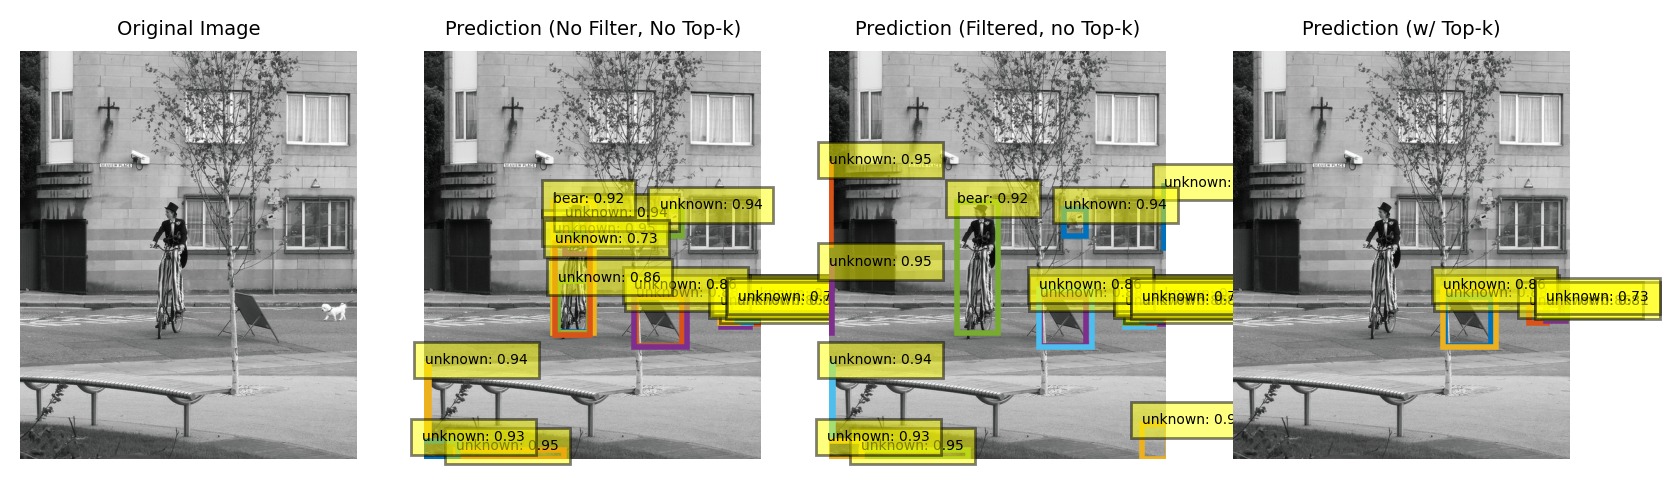

In [17]:
viz_single_img(model, criterion, "samples/000000289343.jpg", args.dataset, args.device, allow_unknown=True)

## 